---

<center>
<h1>Pronóstico de la productividad forrajera y balance</h1>
<h1>hídrico en la región de los pastizales del Río de la Plata</h1>
</center>

---


<br>
<br>
<ul>
    <li>Bartol, Tomás Augusto</li>
    <li>Peiretti, Pablo </li>
    <li>Sánchez, Milagros Verónica </li>
</li>
</ul>


<br>
<h2>Abstract</h2>

This notebook was created with the purpose of introducing the use of multispectral satellite images as a tool for predicting forage production and water balance in the grasslands of the Río de la Plata. Based on this, the aim is to achieve a more efficient and precise management of resources. Additionally, there will be an attempt to increase livestock productivity by reducing variability in forage production. 

---

# Modules 

This section contains the import statements for external Python modules that are used throughout the notebook. This section is where external libraries or packages are loaded in order to provide additional functionality beyond the basic Python capabilities


In [1]:
### Load the modules ### 
import sys
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ipywidgets as widgets

### Load In-House modules ###  
sys.path.append('../src/')
import data
import reporting
import models


--- 

# Macros 

The Globals and Macros section in this codebase serves as a centralized hub for managing global variables and macros that impact the entire project. This section is dedicated to storing constants, configuration parameters, and reusable macros that streamline the development process and ensure consistency across various components.

---

# Data

In this dedicated segment, our primary emphasis will be on the comprehensive visualization and skillful manipulation of the data provided by the MODIS remote sensor. We will delve into the intricacies of presenting the information in a visually impactful manner, ensuring that we not only harness the power of visualization techniques but also adeptly navigate the nuances of manipulating the MODIS dataset for meaningful insights.

In [2]:
ppna_df = data.ppna_database_ingest('PPNA_denso_16d_fechas_ordenadas.csv')
temp_df = data.temp_database_ingest('TEMP_denso_16d_fechas_ordenadas.csv')
ppt_df = data.ppt_database_ingest('PPT_denso_16d_fechas_ordenadas.csv')
date_df = data.date_database_ingest('fechas modis ANII.csv')
cord_df = data.cord_database_ingest ('xy_denso.csv')
ppna_df = data.DataManager(data.merge_databases(ppna_df,temp_df,ppt_df,cord_df,date_df))
ppna_df.info()

<class 'data.data_manager.DataManager'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ppna       690000 non-null  float64       
 1   temp       690000 non-null  float64       
 2   ppt        690000 non-null  float64       
 3   date       690000 non-null  datetime64[ns]
 4   latitude   690000 non-null  float64       
 5   longitude  690000 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 31.6 MB



## Data Visualization 


In [3]:
ppna_df.head()

,ppna,temp,ppt,date,latitude,longitude
0,405.340618,24.333897,76.155505,2001-01-01,-31.544792,-56.83242
1,362.433361,23.921929,91.647396,2001-01-17,-31.544792,-56.83242
2,420.441046,24.132180,80.999538,2001-02-02,-31.544792,-56.83242
3,335.261458,26.170466,88.673292,2001-02-18,-31.544792,-56.83242
4,301.399079,24.043910,5.496469,2001-03-06,-31.544792,-56.83242


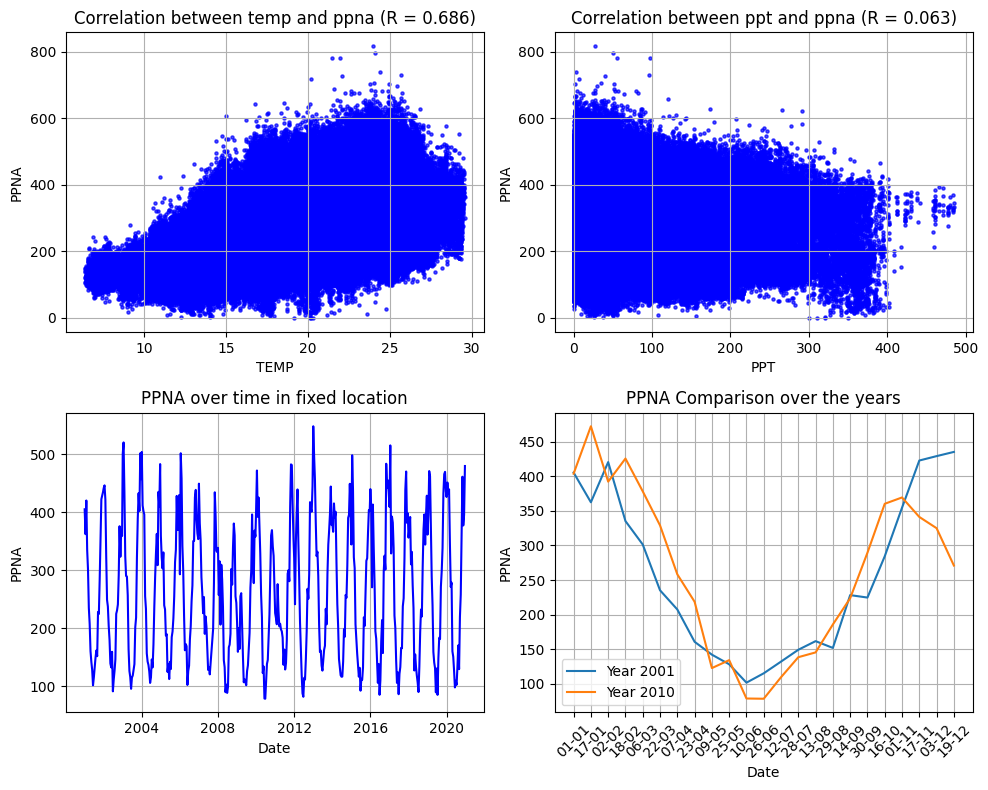

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

reporting.show_correlation(ppna_df, axes[0,0], 'temp', 'ppna')
reporting.show_correlation(ppna_df, axes[0,1], 'ppt', 'ppna')
reporting.show_ppna_fixed_position(ppna_df, axes[1,0], ppna_df['latitude'][100], ppna_df['longitude'][100])
reporting.show_ppna_year_comparision_fixed_position(ppna_df,axes[1,1], 2001, 2010, ppna_df['latitude'][0], ppna_df['longitude'][0])

fig.tight_layout()
plt.show()

## Data Managment

In [5]:
"""
Convert from date to timestamp foamat
""" 
ppna_df.date_to_timestamp()

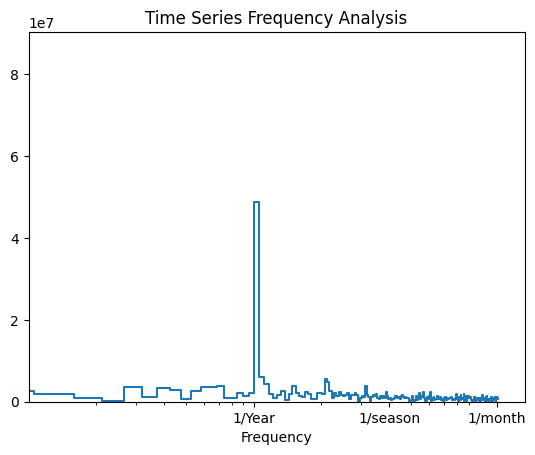

In [6]:
"""
Temporal periodicity analysis of our data set, where it can be seen that it has a very important annual periodicity.
"""

# group dataframe by date 
combined_series = ppna_df.groupby(['date'])['ppna'].sum().sort_index()


# Apply FFT
fft = tf.signal.rfft(combined_series)
f_per_dataset = np.arange(0, len(fft))


n_samples_h = len(combined_series)
f_sample = 15 #1 sample every 15 days 
years_per_dataset = n_samples_h * f_sample / 365  #number of samples * frecuency sample day * num of days in a year give me the number of years 
f_per_year = f_per_dataset / years_per_dataset

# Grafica la amplitud de las frecuencias en una escala de logaritmo.
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, max( np.abs(fft) /2))
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 4, 12], labels=['1/Year', '1/season', '1/month'])
plt.title('Time Series Frequency Analysis' )
plt.xlabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Time signal')

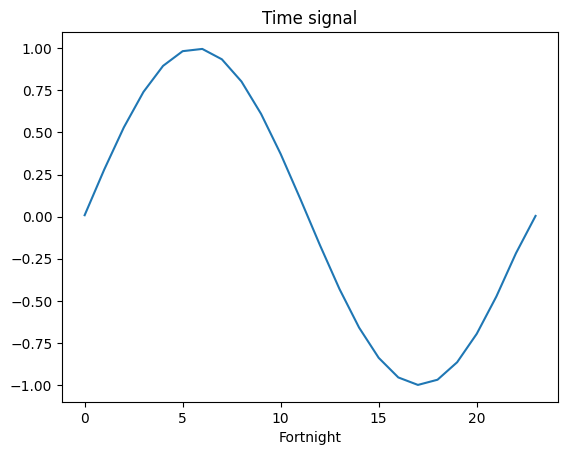

In [7]:
"""
Time in seconds is not a useful input for the model. Being meteorological data, it exhibits clear daily and annual periodicity. There are many ways to deal with this periodicity.
You can obtain usable signals by using sine and cosine transformations to remove the "Time of day" and "Time of year" signals.
As we previously analyzed, the most important time dependence is annual, therefore, we will use a time signal with an annual period.
"""
day = 24*60*60
year = (365.2425)*day


ppna_df['date_signal'] = np.sin(ppna_df['timestamp_date'] * (2 * np.pi / year))

plt.plot(np.array(ppna_df['date_signal'])[:24]) #veinticinco muestras son casi un año (15 * 24 = 360 dias) y vemos ue se cumple un periodo de la señal temporal
plt.xlabel('Fortnight')
plt.title('Time signal')



In [8]:
"""
Divide the dataframe into three sections (train, test, validation) with roughly a 70-20-10 distribution. 
As we have 20 years of data, it is going to be diveded into 14 years, 4 years and 2 years (70%,20% and 10%).
The samples are divided secuentially to improve the RNN performance.
"""
train_df = data.DataManager(ppna_df[ppna_df['date'] < '2014-01-01'][[ 'date_signal', 'latitude', 'longitude', 'ppt','temp', 'ppna']])
val_df =  data.DataManager(ppna_df[(ppna_df['date'] >= '2014-01-01') & (ppna_df['date'] < '2019-01-01')][[ 'date_signal', 'latitude', 'longitude', 'ppt', 'temp', 'ppna']])
test_df = data.DataManager(ppna_df[ppna_df['date'] >= '2019-01-01'][['date_signal', 'latitude', 'longitude', 'ppt','temp', 'ppna']])

In [9]:
"""
Normalization of every dataframe. The chosen normalization uses mean and standard deviation
Every Dataframe must be normalized by the same values, hence the train df mean and deviation are saved

(También es discutible que el modelo no debería tener acceso a valores futuros en el conjunto de entrenamiento 
durante el entrenamiento, y que esta normalización debería hacerse usando promedios móviles. Ese no es el enfoque 
de este tutorial, y los conjuntos de validación y prueba aseguran que obtenga métricas (algo) honestas. 
Entonces, en aras de la simplicidad, este tutorial usa un promedio simple.) 

https://medium.com/@spinjosovsky/normalize-data-before-or-after-split-of-training-and-testing-data-7b8005f81e26
https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well
"""
train_df.normalize_data()
val_df.normalize_data()
test_df.normalize_data()

--- 

# Recurrent Neuronal Network

In this section, we delve into the examination and analysis of various topologies within recurrent neural networks (RNNs) with the primary goal of estimating and predicting the productivity of forage production. Forage production, a critical aspect of agricultural ecosystems, can be influenced by a multitude of factors, and leveraging the capabilities of RNNs allows us to capture the temporal dependencies inherent in such dynamic systems.

## LSTM - Multivariable 

We will embark on the construction of a Long Short-Term Memory (LSTM) neural network tailored for the PPNA. Leveraging the power of LSTM architecture, we aim to develop a robust model capable of capturing temporal dependencies within the data, ultimately enhancing our ability to forecast PPNA trends. Throughout this endeavor, we will explore the intricacies of LSTM networks, fine-tune model parameters, and implement effective training strategies to optimize predictive accuracy.

A recurrent model can learn to use a long history of inputs if it is relevant for the predictions the model makes. 
Here, the model will accumulate internal state over a year (24 samples) before making a single prediction for the next 15 days (1 sample).

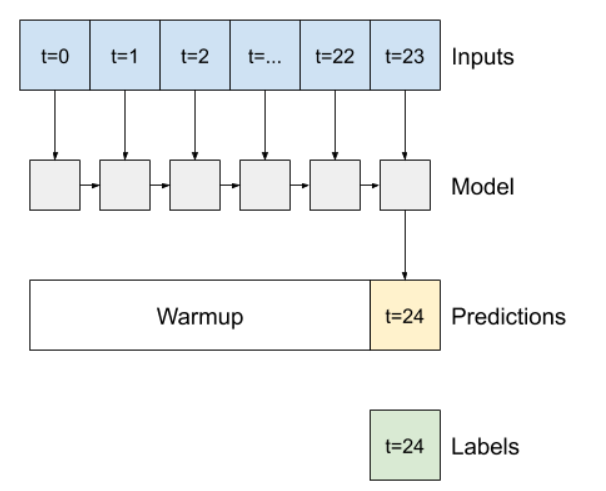

In [10]:
INPUT_STEPS = 24 #1 Year
OUTPUT_STEPS = 12 #The amount of days to be forecasted is given by the equation 15*OUTPUT_STEPS = # of days
train_sequence, train_labels = train_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
val_sequence, val_labels = val_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence, test_labels = test_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
print("train sequence: (num train data, past_data, features) ->", test_sequence.shape)
print("label sequence: (num train data, output_steps) -> ", test_labels.shape)

train sequence: (num train data, past_data, features) -> (68965, 24, 6)
label sequence: (num train data, output_steps) ->  (68965, 12)


In [11]:
"""
If you want to create a new model it has to be defined in /src/model
"""
modelLstm= models.modelLstm(INPUT_STEPS, OUTPUT_STEPS, train_df.shape[1], 1)

"""
The .fit method is a crucial step in the machine learning workflow, where a model learns patterns and relationships 
from a training dataset. During the training process, the model adjusts its internal parameters based on the input 
data and corresponding target values. The goal is to minimize the difference between the model's predictions and the
 actual target values. The training process involves iteratively updating the model parameters through techniques like 
 gradient descent or other optimization algorithms.
"""

EPOCHS = 5
history = modelLstm.fit(train_sequence, train_labels, validation_data=(val_sequence,val_labels), epochs=EPOCHS, batch_size=32)
modelLstm.save('../models/modelLstm128')

"""
If you want to use a serialized model change the variable modelName, load from /models/ and comment the above block of code 
"""
#modelName = 'modelLstm128'
#model = tf.keras.models.load_model(f'../models/{modelName}')



Epoch 1/5

14015/14015 [==============================] - 293s 21ms/step - loss: 0.6936 - root_mean_squared_error: 0.8328 - val_loss: 0.2920 - val_root_mean_squared_error: 0.5403
Epoch 2/5
14015/14015 [==============================] - 257s 18ms/step - loss: 0.2845 - root_mean_squared_error: 0.5334 - val_loss: 0.2226 - val_root_mean_squared_error: 0.4718
Epoch 3/5
14015/14015 [==============================] - 343s 24ms/step - loss: 0.2570 - root_mean_squared_error: 0.5069 - val_loss: 0.2206 - val_root_mean_squared_error: 0.4697
Epoch 4/5
14015/14015 [==============================] - 275s 20ms/step - loss: 0.2454 - root_mean_squared_error: 0.4953 - val_loss: 0.2208 - val_root_mean_squared_error: 0.4699
Epoch 5/5
14015/14015 [==============================] - 325s 23ms/step - loss: 0.2368 - root_mean_squared_error: 0.4867 - val_loss: 0.2230 - val_root_mean_squared_error: 0.4722
INFO:tensorflow:Assets written to: ../models/modelLstm128\assets


INFO:tensorflow:Assets written to: ../models/modelLstm128\assets


'\nIf you want to use a serialized model change the variable modelName, load from /models/ and comment the above block of code \n'

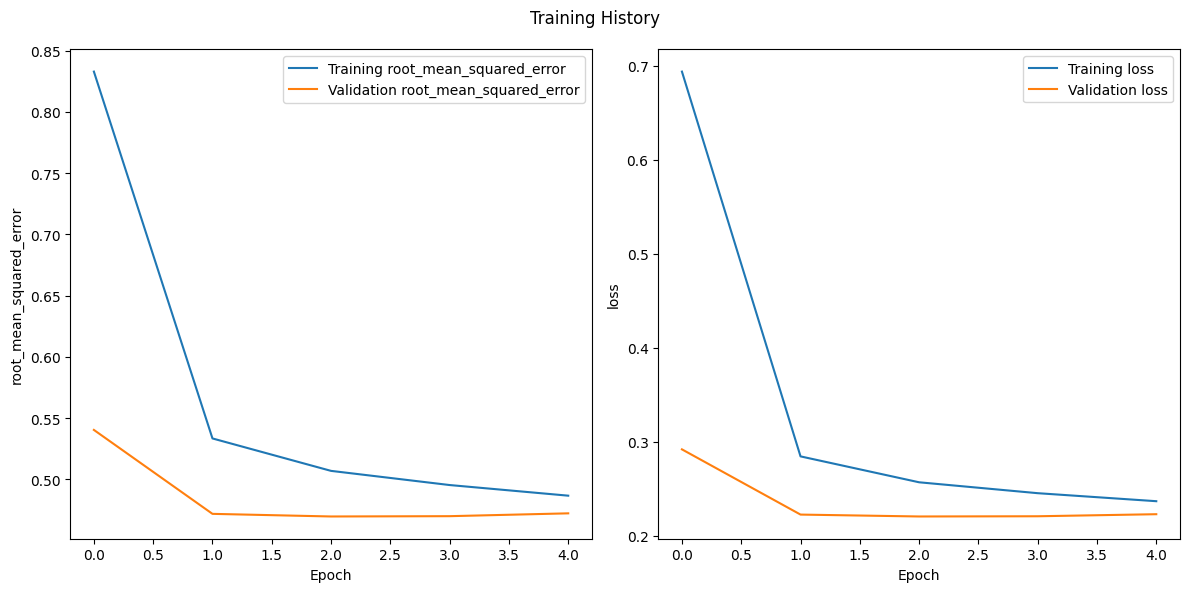

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# plot training history
reporting.plot_training_history(axes[0], history, "root_mean_squared_error")
reporting.plot_training_history(axes[1], history, "loss")

# Mostrar el gráfico
fig.suptitle("Training History")
fig.tight_layout()
plt.show()


In [15]:
index_slider = widgets.IntSlider(min=0, max=OUTPUT_STEPS-2 , step=1, value=0, description='Fortnight:', layout=widgets.Layout(width='60%', margin='0px 0px 0px 0px'))

def update_plot(index):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    fig.suptitle('Model Resuts')
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    reporting.plot_result_in_fixed_position(axes[0,0],ppna_df['longitude'][400000], ppna_df['latitude'][400000],index, modelLstm, test_df,INPUT_STEPS,OUTPUT_STEPS)
    reporting.plot_result_in_fixed_position(axes[0,1],ppna_df['longitude'][0], ppna_df['latitude'][0],index,  modelLstm, test_df,INPUT_STEPS,OUTPUT_STEPS)
    reporting.plot_result_in_fixed_position(axes[1,0],ppna_df['longitude'][10000], ppna_df['latitude'][10000],index,  modelLstm, test_df,INPUT_STEPS,OUTPUT_STEPS)
    reporting.plot_result_in_fixed_position(axes[1,1],ppna_df['longitude'][30000], ppna_df['latitude'][30000],index,   modelLstm, test_df,INPUT_STEPS,OUTPUT_STEPS)
    


widgets.interactive(update_plot, index=index_slider)

interactive(children=(IntSlider(value=0, description='Fortnight:', layout=Layout(margin='0px 0px 0px 0px', wid…